#### <a>Objective: To predict the department-wide sales for each Walmart store.

#### <a>Business Context:

The objective is predicting store sales using historical markdown data. One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.

#### <a>Data Description

We are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and we are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the problem is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.

train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file we will find the following fields:

    Store - the store number
    Dept - the department number
    Date - the week
    Weekly_Sales -  sales for the given department in the given store
    IsHoliday - whether the week is a special holiday week

test.csv

This file is identical to train.csv, except we have withheld the weekly sales. We must predict the sales for each triplet of store, department, and date in this file.

features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

<b><a>Data Source:</a></b> https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

#### <a>Approach to problem solving:

The problem is solved by converting the problem into Regression problem. Weekly_Sales can be considered as dependent(Y) variable and other variables can be considered as independent(X) variables. The important thing is the data preparation.

#### <a>Importing Modules

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas_profiling import ProfileReport

from sklearn.feature_selection import f_regression, RFE, VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import metrics

from scipy import stats
import pylab

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Writing output data into excel
output = pd.ExcelWriter('Walmart_output.xlsx')

#### <a>Creating UDFs

In [3]:
# Create Statistical Summary for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), len(x.value_counts()), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.50),
                      x.quantile(0.99), x.max()], 
                      index = ['Count', 'Unique', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN',
                               'P1', 'P50', 'P99', 'MAX'])

In [4]:
# Create Statistical Summary for categorical variables
def categorical_var_summary(a):
    Mode = a.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([a.count(), a.isnull().sum(), len(a.value_counts()), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(((Mode.iloc[0, 1] * 100)/a.count()), 2)], 
                      index = ['COUNT', 'MISS', 'UNIQUE', 'MODE', 'FREQ', 'PERCENT'])

In [5]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

In [6]:
# Downcast function for int and float to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    
    for i,j in enumerate(types):
        if 'int' in str(j):
            if (df[cols[i]].min()>np.iinfo('int8').min) and (df[cols[i]].max()<np.iinfo('int8').max):
                df[cols[i]] = df[cols[i]].astype('int8')
                
            elif (df[cols[i]].min()>np.iinfo('int16').min) and (df[cols[i]].max()<np.iinfo('int16').max):
                df[cols[i]] = df[cols[i]].astype('int16')
                
            elif (df[cols[i]].min()>np.iinfo('int32').min) and (df[cols[i]].max()<np.iinfo('int32').max):
                df[cols[i]] = df[cols[i]].astype('int32')
                
            else: df[cols[i]] = df[cols[i]].astype('int64')
                
        elif 'float' in str(j):
            if (df[cols[i]].min()>np.finfo('float16').min) and (df[cols[i]].max()<np.finfo('float16').max):
                df[cols[i]] = df[cols[i]].astype('float16')
                
            elif (df[cols[i]].min()>np.finfo('float32').min) and (df[cols[i]].max()<np.finfo('float32').max):
                df[cols[i]] = df[cols[i]].astype('float32')
                
            else: df[cols[i]] = df[cols[i]].astype('float64')
    return df                 

#### <a>Loading Dataset

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

#### <a>Understanding Data

In [8]:
#Merging Datasets
t1 = train_df.merge(features, on = ['Store', 'Date', 'IsHoliday'])
train = t1.merge(stores, on = 'Store')

#Downcasting train dataset
#train = downcast(train)

t2 = test_df.merge(features, on = ['Store', 'Date', 'IsHoliday'])
test= t2.merge(stores, on = 'Store')

#Downcasting test dataset
#test = downcast(test)

In [9]:
#View of the Data
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [10]:
#Data Information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [11]:
#View of the Data
test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315


In [12]:
#Data Information
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday     115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     114915 non-null  float64
 7   MarkDown2     86437 non-null   float64
 8   MarkDown3     105235 non-null  float64
 9   MarkDown4     102176 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           76902 non-null   float64
 12  Unemployment  76902 non-null   float64
 13  Type          115064 non-null  object 
 14  Size          115064 non-null  int64  
dtypes: bool(1), float64(9), int64(3), object(2)
memory usage: 13.3+ MB


In [13]:
#Changing Date column to DateTime type
train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')

In [14]:
#Extracting Date Features
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.week
train['Day'] = train['Date'].dt.day

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.week
test['Day'] = test['Date'].dt.day

#### <a>Exploratory Data Analysis

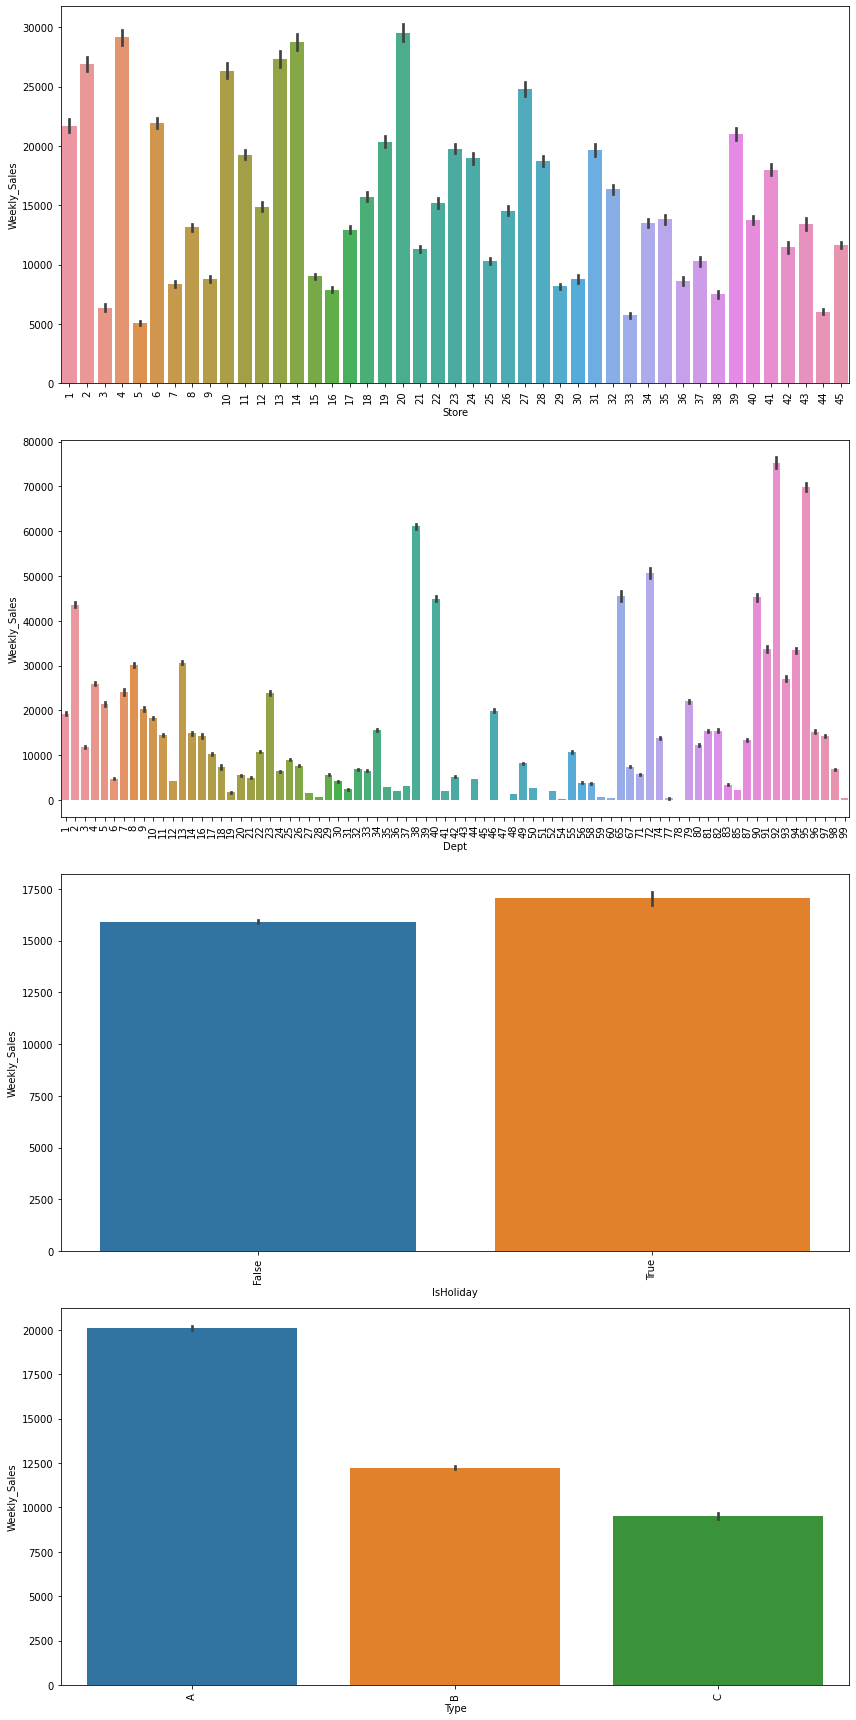

In [15]:
#Visualizing Weekly Sales across different categorical features
plt_cols = ['Store', 'Dept', 'IsHoliday', 'Type']

plt.figure(figsize = (12,24))
for i, col in enumerate(plt_cols):
    plt.subplot(4, 1, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = train[col], y = train.Weekly_Sales)
    plt.xticks(rotation = 90)
    plt.tight_layout()

Observations:

- Store 20 has the highest Sales and Store 5 has the lowest sales
- Department 92 has the highest sales, followed by 95 and 38
- There is high Sales on Holidays
- Type A Stores have very high sales compared to Type B and C Stores

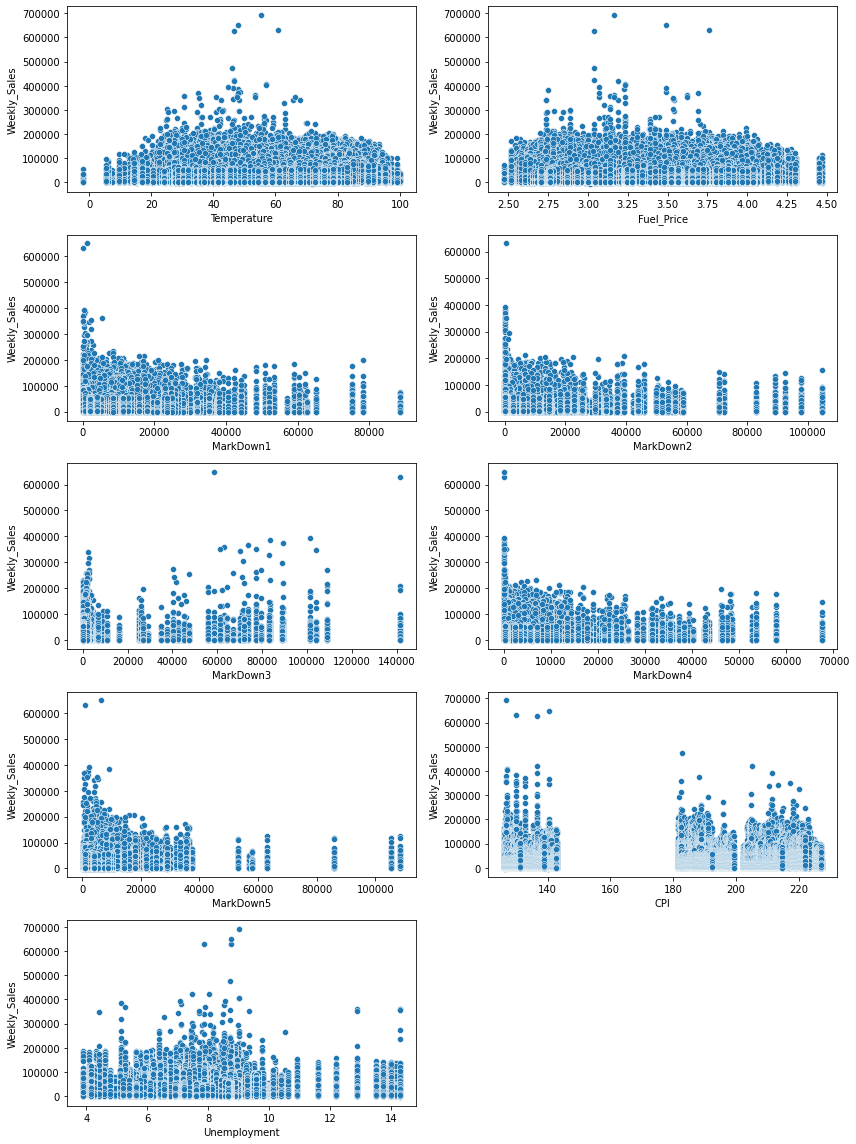

In [16]:
#Visualizing Weekly Sales across different continuous features
plt_cols = ['Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3',
            'MarkDown4','MarkDown5','CPI','Unemployment']

plt.figure(figsize = (12,16))
for i, col in enumerate(plt_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.scatterplot(x = train[col], y = train.Weekly_Sales)
    plt.tight_layout() 

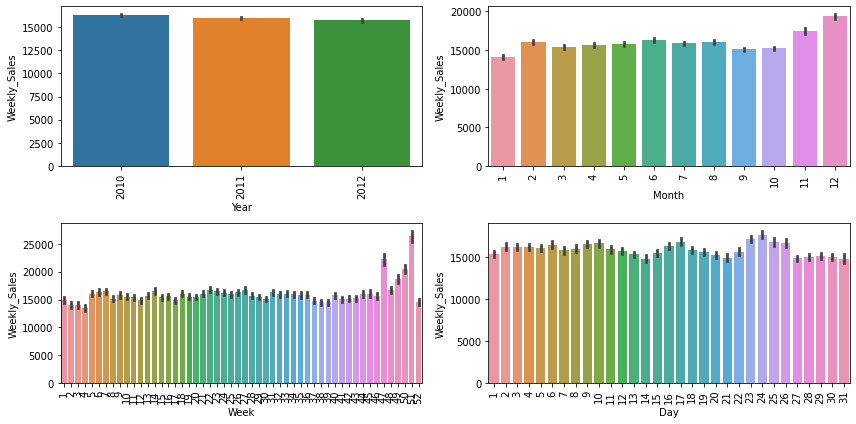

In [17]:
#Visualizing Weekly Sales across different date features
plt_cols = ['Year', 'Month', 'Week', 'Day']

plt.figure(figsize = (12,6))
for i, col in enumerate(plt_cols):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = train[col], y = train.Weekly_Sales)
    plt.xticks(rotation = 90)
    plt.tight_layout() 

Observations:

- Weekly Sales was high in Year 2010
- Weekly Sales are high in November and December
- Weekly Sales are 51 and 47 Week
- Weekly Sales are low during the end of the of the month

#### <a>Statistical Summary

In [18]:
#Getting Categorical and continuous variables
cat_cols = ['Store','Dept','IsHoliday','Type','Year','Month','Week','Day']
cont_cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size','MarkDown1','MarkDown2','MarkDown3',
             'MarkDown4','MarkDown5']

In [19]:
#Summary of train Categorical Variables
cat_summary = train[cat_cols].apply(categorical_var_summary)
cat_summary.to_excel(output, 'Train Statistical Summary', startrow = 3)
cat_summary

,Store,Dept,IsHoliday,Type,Year,Month,Week,Day
COUNT,421570.00,421570.00,421570,421570,421570.0,421570.0,421570.00,421570.00
MISS,0.00,0.00,0,0,0.0,0.0,0.00,0.00
UNIQUE,45.00,81.00,2,3,3.0,12.0,52.00,31.00
MODE,13.00,1.00,False,A,2011.0,4.0,7.00,23.00
FREQ,10474.00,6435.00,391909,215478,153453.0,41332.0,8929.00,14801.00
PERCENT,2.48,1.53,92.96,51.11,36.4,9.8,2.12,3.51


In [20]:
#Summary of train Continuous Variables
cont_summary = train[cont_cols].apply(continuous_var_summary)
cont_summary.to_excel(output, 'Train Statistical Summary', startrow = 13)
cont_summary

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Count,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,1.506810e+05,1.112480e+05,1.370910e+05,1.349670e+05,1.514320e+05
Unique,3.594640e+05,3.528000e+03,8.920000e+02,2.145000e+03,3.490000e+02,4.000000e+01,2.277000e+03,1.499000e+03,1.662000e+03,1.944000e+03,2.293000e+03
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.708890e+05,3.103220e+05,2.844790e+05,2.866030e+05,2.701380e+05
SUM,6.737219e+09,2.533217e+07,1.416908e+06,7.217360e+07,3.355819e+06,5.764039e+10,1.091898e+09,3.709708e+08,1.973317e+08,4.566161e+08,7.009750e+08
MEAN,1.598126e+04,6.009006e+01,3.361027e+00,1.712019e+02,7.960289e+00,1.367279e+05,7.246420e+03,3.334629e+03,1.439421e+03,3.383168e+03,4.628975e+03
MEDIAN,7.612030e+03,6.209000e+01,3.452000e+00,1.823188e+02,7.866000e+00,1.401670e+05,5.347450e+03,1.920000e+02,2.460000e+01,1.481310e+03,3.359450e+03
STD,2.271118e+04,1.844793e+01,4.585145e-01,3.915928e+01,1.863296e+00,6.098058e+04,8.291221e+03,9.475357e+03,9.623078e+03,6.292384e+03,5.962887e+03
VAR,5.157979e+08,3.403262e+02,2.102356e-01,1.533449e+03,3.471872e+00,3.718632e+09,6.874435e+07,8.978240e+07,9.260364e+07,3.959410e+07,3.555603e+07
MIN,-4.988940e+03,-2.060000e+00,2.472000e+00,1.260640e+02,3.879000e+00,3.487500e+04,2.700000e-01,-2.657600e+02,-2.910000e+01,2.200000e-01,1.351600e+02
P1,5.000000e+00,1.830000e+01,2.565000e+00,1.261119e+02,4.156000e+00,3.487500e+04,1.776000e+01,-9.900000e-01,6.000000e-02,3.970000e+00,3.519700e+02


In [21]:
#Summary of test Categorical Variables
cat_summ = test[cat_cols].apply(categorical_var_summary)
cat_summ.to_excel(output, 'Test Statistical Summary', startrow = 3)
cat_summ

,Store,Dept,IsHoliday,Type,Year,Month,Week,Day
COUNT,115064.00,115064.00,115064,115064,115064.00,115064.00,115064.00,115064.00
MISS,0.00,0.00,0,0,0.00,0.00,0.00,0.00
UNIQUE,45.00,81.00,2,3,2.00,9.00,39.00,27.00
MODE,13.00,1.00,False,A,2013.00,11.00,51.00,7.00
FREQ,2836.00,1755.00,106136,58713,88275.00,14824.00,3002.00,5926.00
PERCENT,2.46,1.53,92.24,51.03,76.72,12.88,2.61,5.15


In [22]:
#Summary of test Continuous Variables
cont_summ = test[cont_cols[1:]].apply(continuous_var_summary)
cont_summ.to_excel(output, 'Test Statistical Summary', startrow = 13)
cont_summ

,Temperature,Fuel_Price,CPI,Unemployment,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Count,1.150640e+05,115064.000000,7.690200e+04,76902.000000,1.150640e+05,1.149150e+05,8.643700e+04,1.052350e+05,1.021760e+05,1.150640e+05
Unique,1.236000e+03,297.000000,3.600000e+02,89.000000,4.000000e+01,1.752000e+03,1.257000e+03,1.421000e+03,1.483000e+03,1.754000e+03
NMISS,0.000000e+00,0.000000,3.816200e+04,38162.000000,0.000000e+00,1.490000e+02,2.862700e+04,9.829000e+03,1.288800e+04,0.000000e+00
SUM,6.206760e+06,412107.046000,1.360868e+07,528219.318000,1.570597e+10,8.836063e+08,3.227602e+08,2.528890e+08,3.429250e+08,4.513594e+08
MEAN,5.394180e+01,3.581546,1.769613e+02,6.868733,1.364977e+05,7.689216e+03,3.734052e+03,2.403089e+03,3.356219e+03,3.922681e+03
MEDIAN,5.447000e+01,3.606000,1.923044e+02,6.806000,1.401670e+05,4.842290e+03,7.425900e+02,7.826000e+01,8.409400e+02,2.390430e+03
STD,1.872415e+01,0.239442,4.123997e+01,1.583427,6.110693e+04,1.069876e+04,8.323495e+03,1.376794e+04,7.570502e+03,1.944515e+04
VAR,3.505939e+02,0.057332,1.700735e+03,2.507242,3.734056e+09,1.144635e+08,6.928057e+07,1.895562e+08,5.731249e+07,3.781139e+08
MIN,-7.290000e+00,2.872000,1.312362e+02,3.684000,3.487500e+04,-2.781450e+03,-3.574000e+01,-1.792600e+02,2.200000e-01,-1.851700e+02
P1,1.144000e+01,2.957000,1.312794e+02,3.879000,3.487500e+04,2.084000e+01,2.000000e-02,1.500000e-01,2.610000e+00,2.693000e+02


From Statistical Summary of the data, we can see that there are outliers and missing values in the data.

#### <a>Data Preparation

In [23]:
#Handling Outliers
train[cont_cols] = train[cont_cols].apply(outlier_capping)

#Saving to excel
train[cont_cols].to_excel(output, 'Train Oulier Treatment')

test[cont_cols[1:]] = test[cont_cols[1:]].apply(outlier_capping)

#Saving to excel
test[cont_cols[1:]].to_excel(output, 'Test Oulier Treatment')

In [24]:
#Missing Values in train dataset
train.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Year                 0
Month                0
Week                 0
Day                  0
dtype: int64

In [25]:
#Treating missing values in train dataset
train = train.fillna(0)

In [26]:
#Missing values in test dataset
test.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
Year                0
Month               0
Week                0
Day                 0
dtype: int64

In [27]:
#Treating Missing values in CPI and Unemployment with mean by Department wise for test dataset
test['CPI'] = test[['Store','Dept','CPI']].groupby(['Store','Dept'])['CPI'].transform(lambda x: x.interpolate())
test['Unemployment'] = test[['Store','Dept','Unemployment']].groupby(['Store','Dept'])['Unemployment'].transform(lambda x: x.interpolate())

In [28]:
#Imputing missing vaues in MarkDown with zeros for test dataset
test = test.fillna(0) 

In [29]:
#Checking for missing values
train.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
Day             0
dtype: int64

In [30]:
test.isna().sum()

Store           0
Dept            0
Date            0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
Day             0
dtype: int64

In [31]:
#Saving to excel
train.to_excel(output, 'Train Missing Treatment')
test.to_excel(output, 'Test Missing Treatment')

In [32]:
#Changing categorical to numerical using Label Encoder
le = LabelEncoder()

train['IsHoliday'] = le.fit_transform(train.IsHoliday)
train['Type'] = le.fit_transform(train.Type)

#Saving to excel
train[['IsHoliday', 'Type']].to_excel(output, 'Train Encoded Variables')

test['IsHoliday'] = le.fit_transform(test.IsHoliday)
test['Type'] = le.fit_transform(test.Type)

#Saving to excel
test[['IsHoliday', 'Type']].to_excel(output, 'Test Encoded Variables')

#### <a>Creating new Holiday variable based on given data

In [33]:
#Getting dates of Super Bowl, Labor
new_hdays = ['2010-02-12','2011-02-11','2012-02-10','2013-02-08',
             '2010-09-10','2011-09-09','2012-09-07','2013-09-06',
            '2010-11-26','2011-11-25','2012-11-23','2013-11-29',
            '2010-12-31','2011-12-30','2012-12-28','2013-12-27',]

In [34]:
#Adding new holidays to train and test dataset
train.loc[train.Date.isin(new_hdays), 'IsHoliday'] = 1
test.loc[test.Date.isin(new_hdays), 'IsHoliday'] = 1

In [35]:
#Checking for negative values
(train.drop(['Date'], axis =1)<0).any(0)

Store           False
Dept            False
Weekly_Sales    False
IsHoliday       False
Temperature     False
Fuel_Price      False
MarkDown1       False
MarkDown2        True
MarkDown3       False
MarkDown4       False
MarkDown5       False
CPI             False
Unemployment    False
Type            False
Size            False
Year            False
Month           False
Week            False
Day             False
dtype: bool

In [36]:
#Replacing negative values in MarkDown2 with zeros
train.loc[train.MarkDown2<0,'MarkDown2'] = 0

In [37]:
#Checking again for negative values
(train.drop(['Date'], axis =1)<0).any(0)

Store           False
Dept            False
Weekly_Sales    False
IsHoliday       False
Temperature     False
Fuel_Price      False
MarkDown1       False
MarkDown2       False
MarkDown3       False
MarkDown4       False
MarkDown5       False
CPI             False
Unemployment    False
Type            False
Size            False
Year            False
Month           False
Week            False
Day             False
dtype: bool

In [38]:
#Dropping Date as it has no significance for our prediction model
train.drop('Date', axis = 1, inplace = True)
test_final = test.drop('Date', axis = 1)

In [39]:
#Droping Year and Month from train and test dataset to group the data at week level
train.drop(['Year', 'Month', 'Day'], axis = 1, inplace = True)
test_final.drop(['Year', 'Month', 'Day'], axis = 1, inplace = True)

In [40]:
train.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Week'],
      dtype='object')

In [41]:
#Grouping train data at Store, Department and Week level
train = train.groupby(['Store','Dept','Week']).agg({'Weekly_Sales': 'mean','IsHoliday' : 'max',
              'Temperature' : 'mean', 'Fuel_Price' : 'mean', 'MarkDown1' : 'mean',
              'MarkDown2' : 'mean', 'MarkDown3' : 'mean', 'MarkDown4' : 'mean',
              'MarkDown5' : 'mean', 'CPI' : 'mean', 'Unemployment' : 'mean',
              'Type' : lambda x: x.mode(), 'Size' : 'mean'}).reset_index()

In [42]:
#Saving final train and test dataset to excel
train.to_excel(output, 'Final Train Data')
test_final.to_excel(output, 'Final Test Data')

#### <a>Correlation Matrix

In [43]:
#Checking correlation with the dependant variable - Weekly_Sales
corr_target = train.corrwith(train['Weekly_Sales']).sort_values(ascending = False)
corr_target.to_excel(output, 'Correlation with Target')
corr_target

Weekly_Sales    1.000000
Size            0.257136
Dept            0.131083
MarkDown5       0.098070
MarkDown1       0.093515
MarkDown4       0.067740
MarkDown3       0.041568
Week            0.034751
MarkDown2       0.023422
IsHoliday       0.009146
Temperature    -0.006673
Fuel_Price     -0.007896
Unemployment   -0.023173
CPI            -0.023429
Store          -0.088365
Type           -0.190930
dtype: float64

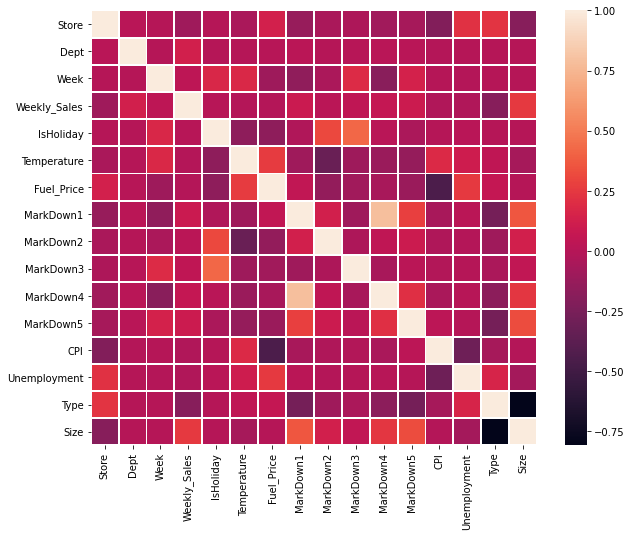

In [44]:
#Correlation matrix heatmap of train dataset
cm = train.corr()
cm.to_excel(output, 'Train Correlation Matrix')

plt.figure(figsize = (10,8))
sns.heatmap(cm, linewidths = 1)
plt.show()

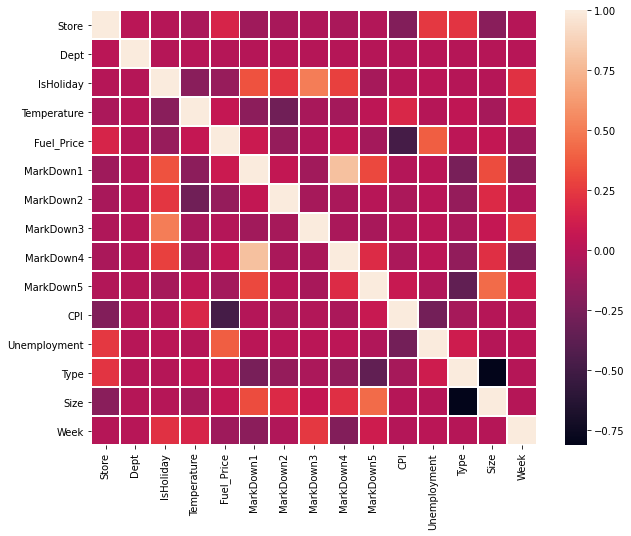

In [45]:
#Correlation matrix heatmap of test dataset
cm1 = test_final.corr()
cm1.to_excel(output, 'Test Correlation Matrix')

plt.figure(figsize = (10,8))
sns.heatmap(cm1, linewidths = 1)
plt.show()

#### <a>Feature Selection

In [46]:
#Defining Target variable and Independent variables
Y = train['Weekly_Sales']
X = train.drop(['Weekly_Sales'], axis = 1)

In [47]:
#Getting Model Formula
model_fm = '''Weekly_Sales ~ Store + Dept + Week + IsHoliday + Temperature + Fuel_Price +
              MarkDown1 + MarkDown2 + MarkDown3 + MarkDown4 + MarkDown5 + CPI + Unemployment
              + Type + Size'''

In [48]:
## Separating the X and Y variables
target, predictor  = dmatrices(model_fm, train, return_type = 'dataframe')

#Calculating VIF for each X and saving in DataFrame
vif = pd.DataFrame()
vif['Features'] = predictor.columns
vif['VIF Factor'] = [variance_inflation_factor(predictor.values, i) for i in range(predictor.shape[1])]

vif.round(1).to_excel(output, 'VIF Result', index = True)

#Getting features
vif_cols = list(set(vif.Features).difference(['Intercept']))

#VIF output
vif.round(1)

,Features,VIF Factor
0,Intercept,481.0
1,Store,1.1
2,Dept,1.0
3,Week,1.2
4,IsHoliday,1.5
5,Temperature,1.5
6,Fuel_Price,1.6
7,MarkDown1,3.1
8,MarkDown2,1.3
9,MarkDown3,1.3


All the features have less than 4 VIF Factor means low multicollinearity. We can proceed with these features for building model.

#### <a>Building Prediction Model - To predict the Weekly Sales

In [49]:
#Getting Train and Test dataset
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 123)

#### <a>Random Forest Model

In [50]:
#Setting Random Forest parameters
rf = RandomForestRegressor(n_estimators = 200, random_state = 123,
                           n_jobs = -1).fit(train_x, train_y)

In [51]:
#Making dataframes to store train and test predicted values 
tr = pd.DataFrame(train_y)
ts = pd.DataFrame(test_y)

#Predicting total spent on train and test dataset
tr.loc[:, 'rf_pred_sales'] = rf.predict(train_x)
ts.loc[:, 'rf_pred_sales'] = rf.predict(test_x)

In [52]:
#R-square Score
rf_r2 = metrics.r2_score(test_y, ts.rf_pred_sales)

print('R-square Score:', rf_r2)

#Getting Mean Squared Error Metric - MSE
rf_MSE_train = metrics.mean_squared_error(train_y, tr.rf_pred_sales)
rf_MSE_test = metrics.mean_squared_error(test_y, ts.rf_pred_sales)

print('\nTraining MSE:', rf_MSE_train,' | ','Testing MSE:', rf_MSE_test)

#Getting Root Mean Squared Error - RMSE
rf_RMSE_train = np.sqrt(rf_MSE_train)
rf_RMSE_test = np.sqrt(rf_MSE_test)

print('Training RMSE: ',rf_RMSE_train,' | ','Testing RMSE:',rf_RMSE_test)

#Getting Mean Absolute Error Metric - MAE
rf_MAE_train = metrics.mean_absolute_error(train_y, tr.rf_pred_sales)
rf_MAE_test = metrics.mean_absolute_error(test_y, ts.rf_pred_sales)

print('\nTraining MAE:', rf_MAE_train, '|', 'Testing MAE:', rf_MAE_test)

#Getting Mean Absolute Percentage Error - MAPE
rf_MAPE_train = np.mean(np.abs(train_y - tr['rf_pred_sales'])/train_y)
rf_MAPE_test = np.mean(np.abs(test_y - ts['rf_pred_sales'])/test_y)
                    
print('\nTraining MAPE:', rf_MAPE_train, '|', 'Testing MAPE:',rf_MAPE_test)

#Getting Root Mean Squared Percentage Error - RMSPE
rf_RMSPE_train = np.sqrt(np.mean(((train_y - tr['rf_pred_sales'])/train_y)**2))
rf_RMSPE_test = np.sqrt(np.mean(((test_y - ts['rf_pred_sales'])/test_y)**2))

print('\nTraining RMSPE:', rf_RMSPE_train,' | ','Testing RMSPE:', rf_RMSPE_test)

R-square Score: 0.98063403020793

Training MSE: 1209311.7203834539  |  Testing MSE: 8199182.973933623
Training RMSE:  1099.6871011262494  |  Testing RMSE: 2863.421550162257

Training MAE: 481.15957886973433 | Testing MAE: 1287.0711221693114

Training MAPE: 0.4473239650236133 | Testing MAPE: 0.9313411880980241

Training RMSPE: 23.911125534081293  |  Testing RMSPE: 23.105761855345637


In [53]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_y, tr.rf_pred_sales)
Corr_test = stats.stats.pearsonr(test_y, ts.rf_pred_sales)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.9985992533373687, 0.0) | Test Data:  (0.990292379252906, 0.0)


In [54]:
#Decile Analysis
#Creating Deciles
tr.loc[:, 'rf_Deciles'] = pd.qcut(tr.rf_pred_sales, 10, labels = False)
ts.loc[:, 'rf_Deciles'] = pd.qcut(ts.rf_pred_sales, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
rf_decile_train = tr.groupby(['rf_Deciles'])[['Weekly_Sales','rf_pred_sales']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)
rf_decile_test = ts.groupby(['rf_Deciles'])[['Weekly_Sales','rf_pred_sales']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)

In [55]:
rf_decile_train.to_excel(output, 'Decile Analysis', startrow=4 , startcol=2, index = False)
rf_decile_train

,rf_Deciles,Weekly_Sales,rf_pred_sales
9,9,66212.194038,65812.983098
8,8,32258.849442,32304.056761
7,7,19815.416319,19907.924481
6,6,13217.912932,13341.764004
5,5,8815.327183,8899.915396
4,4,5687.331054,5764.446726
3,3,3435.838559,3494.533946
2,2,1748.262118,1798.277337
1,1,541.624870,577.091040
0,0,56.270681,64.004708


In [56]:
rf_decile_test.to_excel(output, 'Decile Analysis', startrow=4 , startcol=6, index = False)
rf_decile_test

,rf_Deciles,Weekly_Sales,rf_pred_sales
9,9,65545.212356,65120.864084
8,8,32075.838566,32044.086954
7,7,19744.935838,19940.300002
6,6,13265.383578,13421.384936
5,5,8914.278381,9028.768605
4,4,5758.266644,5868.784814
3,3,3474.500880,3567.657919
2,2,1783.823209,1850.998023
1,1,559.712529,602.531388
0,0,67.405946,73.887474


<BarContainer object of 15 artists>

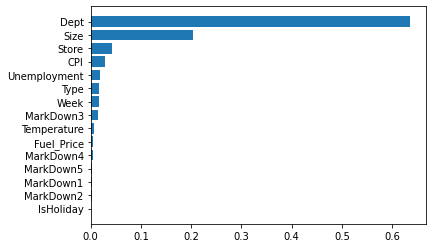

In [57]:
#Feature Impotance for Random Forest Model
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : rf.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

rf_fi.to_excel(output, 'Drivers', startrow=5, startcol=1, index = False)

plt.barh(width = rf_fi.Importance, y = rf_fi.Features)

#### <a>Gradient Boost Model

In [58]:
#Setting Random Forest parameters
gb = GradientBoostingRegressor(n_estimators = 300, random_state = 123).fit(train_x, train_y)

In [59]:
#Predicting total spent on train and test dataset
tr.loc[:, 'gb_pred_sales'] = gb.predict(train_x)
ts.loc[:, 'gb_pred_sales'] = gb.predict(test_x)

In [60]:
#R-square Score
gb_r2 = metrics.r2_score(test_y, ts.gb_pred_sales)

print('R-square Score:', gb_r2)

#Getting Mean Squared Error Metric - MSE
gb_MSE_train = metrics.mean_squared_error(train_y, tr.gb_pred_sales)
gb_MSE_test = metrics.mean_squared_error(test_y, ts.gb_pred_sales)

print('\nTraining MSE:', gb_MSE_train,' | ','Testing MSE:', gb_MSE_test)

#Getting Root Mean Squared Error - RMSE
gb_RMSE_train = np.sqrt(gb_MSE_train)
gb_RMSE_test = np.sqrt(gb_MSE_test)

print('Training RMSE: ',gb_RMSE_train,' | ','Testing RMSE:',gb_RMSE_test)

#Getting Mean Absolute Error Metric - MAE
gb_MAE_train = metrics.mean_absolute_error(train_y, tr.gb_pred_sales)
gb_MAE_test = metrics.mean_absolute_error(test_y, ts.gb_pred_sales)

print('\nTraining MAE:', gb_MAE_train, '|', 'Testing MAE:', gb_MAE_test)

#Getting Mean Absolute Percentage Error - MAPE
gb_MAPE_train = np.mean(np.abs(train_y - tr['gb_pred_sales'])/train_y)
gb_MAPE_test = np.mean(np.abs(test_y - ts['gb_pred_sales'])/test_y)
                    
print('\nTraining MAPE:', gb_MAPE_train, '|', 'Testing MAPE:', gb_MAPE_test)

#Getting Root Mean Squared Percentage Error - RMSPE
gb_RMSPE_train = np.sqrt(np.mean(((train_y - tr['gb_pred_sales'])/train_y)**2))
gb_RMSPE_test = np.sqrt(np.mean(((test_y - ts['gb_pred_sales'])/test_y)**2))

print('\nTraining RMSPE:', gb_RMSPE_train,' | ','Testing RMSPE:', gb_RMSPE_test)

R-square Score: 0.8549313927346014

Training MSE: 61012527.03254419  |  Testing MSE: 61419286.899320394
Training RMSE:  7811.051595818849  |  Testing RMSE: 7837.045801787839

Training MAE: 4968.387935758425 | Testing MAE: 5005.651016371407

Training MAPE: 21.761483870531812 | Testing MAPE: 20.606920106234863

Training RMSPE: 151.15234961900953  |  Testing RMSPE: 135.70501528393987


In [61]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_y, tr.gb_pred_sales)
Corr_test = stats.stats.pearsonr(test_y, ts.gb_pred_sales)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.9280338456176207, 0.0) | Test Data:  (0.9271267892880981, 0.0)


In [62]:
#Decile Analysis
#Creating Deciles
tr.loc[:, 'gb_Deciles'] = pd.qcut(tr.gb_pred_sales, 10, labels = False)
ts.loc[:, 'gb_Deciles'] = pd.qcut(ts.gb_pred_sales, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
gb_decile_train = tr.groupby(['gb_Deciles'])[['Weekly_Sales','gb_pred_sales']].mean().reset_index().sort_values(by = 'gb_Deciles', ascending = False)
gb_decile_test = ts.groupby(['gb_Deciles'])[['Weekly_Sales','gb_pred_sales']].mean().reset_index().sort_values(by = 'gb_Deciles', ascending = False)

In [63]:
gb_decile_train.to_excel(output, 'Decile Analysis', startrow=4 , startcol=10, index = False)
gb_decile_train

,gb_Deciles,Weekly_Sales,gb_pred_sales
9,9,63046.480530,58305.899727
8,8,30755.563535,30431.847535
7,7,19872.306389,19972.046942
6,6,13358.869150,14368.326324
5,5,8819.448990,10637.870461
4,4,6515.264953,7948.992611
3,3,4324.470939,5776.322899
2,2,2854.411107,3801.932947
1,1,1645.106010,1787.549679
0,0,598.553284,-1239.868044


In [64]:
gb_decile_test.to_excel(output, 'Decile Analysis', startrow=4 , startcol=14, index = False)
gb_decile_test

,gb_Deciles,Weekly_Sales,gb_pred_sales
9,9,62846.108824,58173.889420
8,8,30607.491022,30142.634224
7,7,19601.799007,19881.265942
6,6,13275.912510,14387.046217
5,5,8852.304372,10643.033773
4,4,6637.150161,7970.038442
3,3,4311.914619,5794.035350
2,2,2835.019438,3804.758776
1,1,1628.426662,1754.270825
0,0,593.554579,-1231.938545


<BarContainer object of 15 artists>

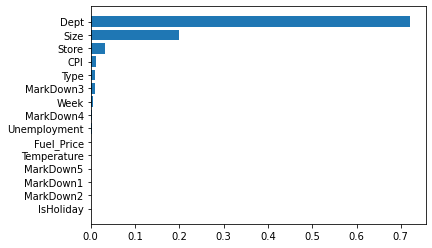

In [65]:
#Feature Impotance for Random Forest Model
gb_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : gb.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

gb_fi.to_excel(output, 'Drivers', startrow=22, startcol=1, index = False)

plt.barh(width = gb_fi.Importance, y = gb_fi.Features)

#### <a>Extra Tree Model

In [66]:
#Setting Random Forest parameters
et = ExtraTreesRegressor(n_estimators = 100, random_state = 123,
                           n_jobs = -1).fit(train_x, train_y)

In [67]:
#Making dataframes to store train and test predicted values 
tr = pd.DataFrame(train_y)
ts = pd.DataFrame(test_y)

#Predicting total spent on train and test dataset
tr.loc[:, 'et_pred_sales'] = et.predict(train_x)
ts.loc[:, 'et_pred_sales'] = et.predict(test_x)

In [68]:
#R-square Score
et_r2 = metrics.r2_score(test_y, ts.et_pred_sales)

print('R-square Score:', et_r2)

#Getting Mean Squared Error Metric - MSE
et_MSE_train = metrics.mean_squared_error(train_y, tr.et_pred_sales)
et_MSE_test = metrics.mean_squared_error(test_y, ts.et_pred_sales)

print('\nTraining MSE:', et_MSE_train,' | ','Testing MSE:', et_MSE_test)

#Getting Root Mean Squared Error - RMSE
et_RMSE_train = np.sqrt(et_MSE_train)
et_RMSE_test = np.sqrt(et_MSE_test)

print('Training RMSE: ',et_RMSE_train,' | ','Testing RMSE:',et_RMSE_test)

#Getting Mean Absolute Error Metric - MAE
et_MAE_train = metrics.mean_absolute_error(train_y, tr.et_pred_sales)
et_MAE_test = metrics.mean_absolute_error(test_y, ts.et_pred_sales)

print('\nTraining MAE:', et_MAE_train, '|', 'Testing MAE:', et_MAE_test)

#Getting Mean Absolute Percentage Error - MAPE
et_MAPE_train = np.mean(np.abs(train_y - tr['et_pred_sales'])/train_y)
et_MAPE_test = np.mean(np.abs(test_y - ts['et_pred_sales'])/test_y)
                    
print('\nTraining MAPE:', et_MAPE_train, '|', 'Testing MAPE:', et_MAPE_test)

#Getting Root Mean Squared Percentage Error - RMSPE
et_RMSPE_train = np.sqrt(np.mean(((train_y - tr['et_pred_sales'])/train_y)**2))
et_RMSPE_test = np.sqrt(np.mean(((test_y - ts['et_pred_sales'])/test_y)**2))

print('\nTraining RMSPE:', et_RMSPE_train,' | ','Testing RMSPE:', et_RMSPE_test)

R-square Score: 0.9798446142811575

Training MSE: 1.1439759315709265e-21  |  Testing MSE: 8533406.650601516
Training RMSE:  3.382271324969253e-11  |  Testing RMSE: 2921.199522559443

Training MAE: 1.787987707836186e-11 | Testing MAE: 1298.7932735280244

Training MAPE: 1.1480084414093643e-15 | Testing MAPE: 1.266209043363838

Training RMSPE: 1.3547419577662635e-15  |  Testing RMSPE: 17.792611068759438


In [69]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_y, tr.et_pred_sales)
Corr_test = stats.stats.pearsonr(test_y, ts.et_pred_sales)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (1.0, 0.0) | Test Data:  (0.9899391788059833, 0.0)


In [70]:
#Decile Analysis
#Creating Deciles
tr.loc[:, 'et_Deciles'] = pd.qcut(tr.et_pred_sales, 10, labels = False)
ts.loc[:, 'et_Deciles'] = pd.qcut(ts.et_pred_sales, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
et_decile_train = tr.groupby(['et_Deciles'])[['Weekly_Sales','et_pred_sales']].mean().reset_index().sort_values(by = 'et_Deciles', ascending = False)
et_decile_test = ts.groupby(['et_Deciles'])[['Weekly_Sales','et_pred_sales']].mean().reset_index().sort_values(by = 'et_Deciles', ascending = False)

In [71]:
et_decile_train.to_excel(output, 'Decile Analysis', startrow=4 , startcol=18, index = False)
et_decile_train

,et_Deciles,Weekly_Sales,et_pred_sales
9,9,66278.891394,66278.891394
8,8,32260.929910,32260.929910
7,7,19812.803740,19812.803740
6,6,13206.864986,13206.864986
5,5,8799.051027,8799.051027
4,4,5675.300217,5675.300217
3,3,3431.636514,3431.636514
2,2,1738.112894,1738.112894
1,1,534.922433,534.922433
0,0,50.511284,50.511284


In [72]:
et_decile_test.to_excel(output, 'Decile Analysis', startrow=4 , startcol=22, index = False)
et_decile_test

,et_Deciles,Weekly_Sales,et_pred_sales
9,9,65570.249235,64849.604615
8,8,32041.150776,31902.710288
7,7,19751.599299,19905.370530
6,6,13240.063440,13468.118179
5,5,8913.199416,9100.269293
4,4,5742.758953,5970.841271
3,3,3486.867537,3688.784949
2,2,1785.737951,1948.391680
1,1,580.843189,669.555591
0,0,76.886146,92.704078


<BarContainer object of 15 artists>

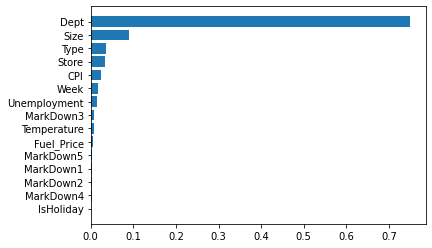

In [73]:
#Feature Impotance for Random Forest Model
et_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : et.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

et_fi.to_excel(output, 'Drivers', startrow=39, startcol=1, index = False)

plt.barh(width = et_fi.Importance, y = et_fi.Features)

#### <a>Evaluating the different metrics for each model

In [74]:
#Getting accuracy and log loss for each model
model_data = pd.DataFrame({'Regressor' : ['RandomForestRegressor', 'GradientBoostingRegressor', 'ExtraTreeRegressor'],
                        'Test_R2 Score' : [rf_r2, gb_r2, et_r2],
                        'MAE_train' : [rf_MAE_train, gb_MAE_train, et_MAE_train],
                        'MAE_test' : [rf_MAE_test, gb_MAE_test, et_MAE_test],
                        'MSE_train' : [rf_MSE_train, gb_MSE_train, et_MSE_train],
                        'MSE_test' : [rf_MSE_test, gb_MSE_test, et_MSE_test],   
                        'RMSE_train' : [rf_RMSE_train, gb_RMSE_train, et_RMSE_train],
                        'RMSE_test' : [rf_RMSE_test, gb_RMSE_test, et_RMSE_test],
                        'RMSPE_train' : [rf_RMSPE_train, gb_RMSPE_train, et_RMSPE_train],  
                        'RMSPE_test' : [rf_RMSPE_test, gb_RMSPE_test, et_RMSPE_test]
                        })

In [75]:
model_data.round(2).to_excel(output, 'Metrics of Models', index = False)
model_data

,Regressor,Test_R2 Score,MAE_train,MAE_test,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSPE_train,RMSPE_test
0,RandomForestRegressor,0.980634,4.811596e+02,1287.071122,1.209312e+06,8.199183e+06,1.099687e+03,2863.421550,2.391113e+01,23.105762
1,GradientBoostingRegressor,0.854931,4.968388e+03,5005.651016,6.101253e+07,6.141929e+07,7.811052e+03,7837.045802,1.511523e+02,135.705015
2,ExtraTreeRegressor,0.979845,1.787988e-11,1298.793274,1.143976e-21,8.533407e+06,3.382271e-11,2921.199523,1.354742e-15,17.792611


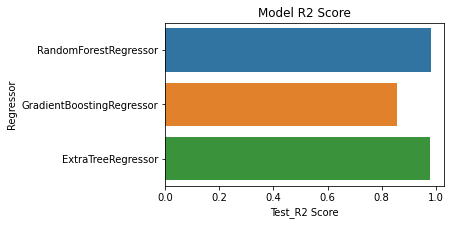

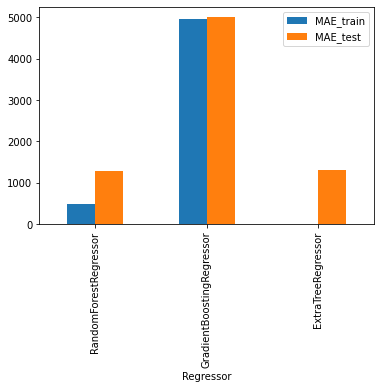

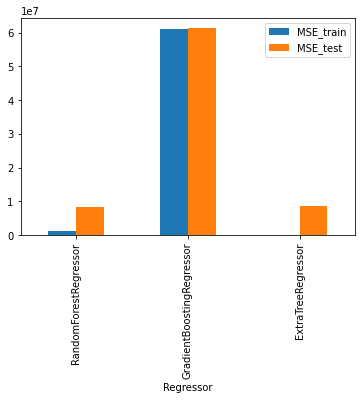

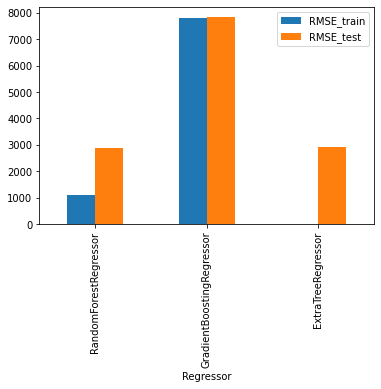

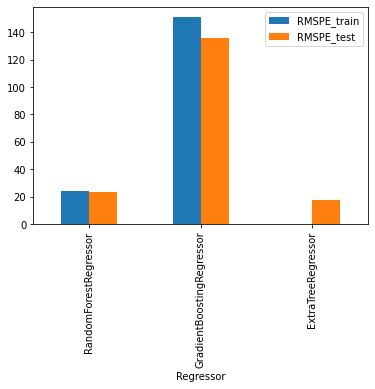

In [76]:
#Visualizing different metrics of the models
plt.figure(figsize = (5,3))
sns.barplot(data = model_data, x = model_data['Test_R2 Score'], y = model_data.Regressor)
plt.title('Model R2 Score')

model_data.plot(x = 'Regressor', y = ['MAE_train', 'MAE_test'], kind = 'bar')
model_data.plot(x = 'Regressor', y = ['MSE_train', 'MSE_test'], kind = 'bar')
model_data.plot(x = 'Regressor', y = ['RMSE_train', 'RMSE_test'], kind = 'bar')
model_data.plot(x = 'Regressor', y = ['RMSPE_train', 'RMSPE_test'], kind = 'bar')

plt.show()

From above charts of metrics, we can conclude that Random Forest Model performs best on train dataset. We can use Random Forest Model to predict Weekly Sales for Walmart Stores. 

In [77]:
# Making Final Prediction on provided test dataset using Random Forest Model
test['Weekly_Sales'] = rf.predict(test_final)

final_pred = pd.DataFrame({
             'Id' : test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),
             'Weekly_Sales' : test.Weekly_Sales
                        })

#Saving prediction on test dataset to excel
final_pred.to_excel(output, 'Predicted Weekly Sales', index = False)

In [78]:
#Predicted Weekly Sales
final_pred

,Id,Weekly_Sales
0,1_1_2012-11-02,9728.911600
1,1_2_2012-11-02,8816.172767
2,1_3_2012-11-02,4729.196675
3,1_4_2012-11-02,10843.212358
4,1_5_2012-11-02,12300.800842
...,...,...
115059,45_93_2013-07-26,11034.837017
115060,45_94_2013-07-26,23797.555583
115061,45_95_2013-07-26,29991.470025
115062,45_97_2013-07-26,6899.975000


In [79]:
output.save()